In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

## Reload preprocessed data

See the `Input data` notebook for generating these compressed pickle files.

# Hotspotting

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np

import open_cp.network
import open_cp.geometry
import open_cp.network_hotspot
import open_cp.logger
open_cp.logger.log_to_true_stdout()

In [3]:
import pickle, lzma
with lzma.open("input_old.pic.xz", "rb") as f:
    timed_points = pickle.load(f)
print(timed_points.time_range)
with open("input.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

(numpy.datetime64('2001-01-01T11:30:00.000'), numpy.datetime64('2014-05-24T18:00:00.000'))


In [4]:
trainer = open_cp.network_hotspot.Trainer()
trainer.graph = graph
trainer.maximum_edge_length = 20
trainer.data = timed_points
predictor = trainer.compile()

[(565000, 567000), (362000, 364000), <matplotlib.text.Text at 0x7f46fd888b70>]

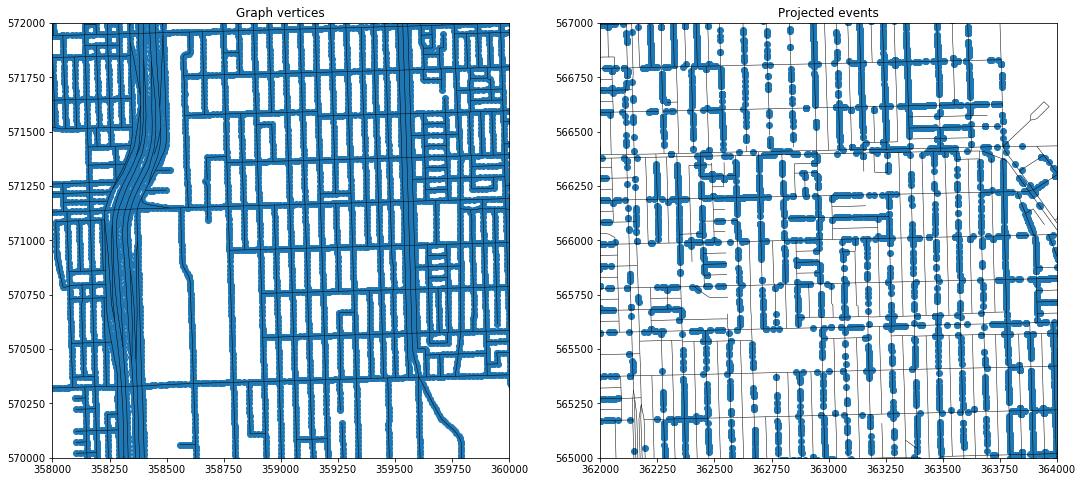

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
    ax.add_collection(lc)

xcs, ycs = [], []
for x, y in predictor.graph.vertices.values():
    xcs.append(x)
    ycs.append(y)
axes[0].scatter(xcs, ycs)
    
tp = predictor.network_timed_points.to_timed_points(predictor.graph)
axes[1].scatter(tp.xcoords, tp.ycoords)

axes[0].set(xlim=[358000, 360000], ylim=[570000, 572000], title="Graph vertices")
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000], title="Projected events")

In [6]:
predictor.time_kernel = open_cp.network_hotspot.ExponentialTimeKernel(20)
predictor.kernel = open_cp.network_hotspot.TriangleKernel(50)
result = predictor.predict()

In [7]:
_cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}
yellow_to_red = matplotlib.colors.LinearSegmentedColormap("yellow_to_red", _cdict)

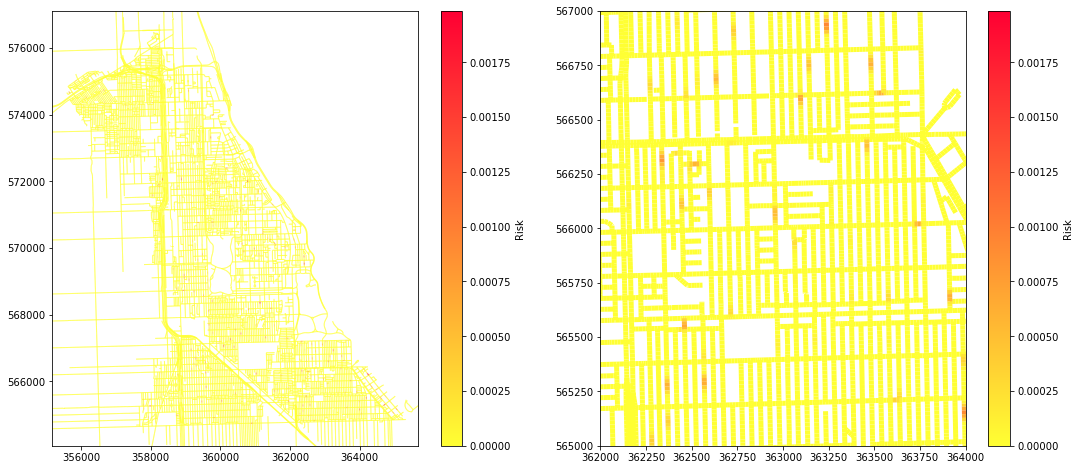

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax, lw in zip(axes, [1,5]):
    lc = matplotlib.collections.LineCollection(result.graph.as_lines(), linewidth=lw, cmap=yellow_to_red)
    lc.set_array(result.risks)
    ax.add_collection(lc)

    cbar = fig.colorbar(lc, orientation="vertical", ax=ax)
    cbar.set_label("Risk")

xmin, ymin, xmax, ymax = *timed_points.bounding_box.min, *timed_points.bounding_box.max
xd, yd = xmax - xmin, ymax - ymin
axes[0].set(xlim=(xmin-xd/20, xmax+xd/20), ylim=(ymin-yd/20, ymax+yd/20))
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000])
None

# Making faster predictions

The above works well for a small cutoff of 50 meters in the space kernel.  This is unrealistic, however.  We instead make an approximation...

In [9]:
timed_points.time_range

(numpy.datetime64('2001-01-01T11:30:00.000'),
 numpy.datetime64('2014-05-24T18:00:00.000'))

In [10]:
trainer = open_cp.network_hotspot.Trainer()
trainer.graph = graph
trainer.maximum_edge_length = 20
mask = ( (timed_points.timestamps >= np.datetime64("2011-01-01")) &
    (timed_points.timestamps < np.datetime64("2011-09-01")) )
trainer.data = timed_points[mask]
predictor = trainer.compile()

In [13]:
pred = open_cp.network_hotspot.ApproxPredictorCaching(predictor)
pred.kernel = open_cp.network_hotspot.TriangleKernel(50)
pred.time_kernel = open_cp.network_hotspot.ExponentialTimeKernel(20)
result_approx = pred.predict()

In [16]:
with lzma.open("approx_predictor_cache.pic.xz", "wb") as f:
    pickle.dump(pred._cache, f)

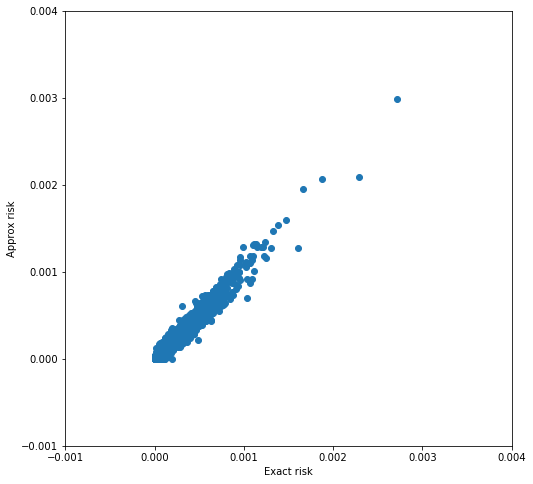

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(result.risks, result_approx.risks)
ax.set(xlim=[-0.001, 0.004], ylim=[-0.001, 0.004])
ax.set(xlabel="Exact risk", ylabel="Approx risk")
None

## Reload

No _official_ library support for this, but it sort of works...

Shows that it's much quicker to make a re-run...

In [13]:
pred = open_cp.network_hotspot.ApproxPredictorCaching(predictor)
pred.kernel = open_cp.network_hotspot.TriangleKernel(50)
pred.time_kernel = open_cp.network_hotspot.ExponentialTimeKernel(20)

fn = os.path.join("/media", "disk", "approx_predictor_cache.pic.xz")
with lzma.open(fn, "rb") as f:
    pred._cache = pickle.load(f)

In [15]:
pred.kernel = open_cp.network_hotspot.TriangleKernel(500)
pred.predict()